In [5]:
data = np.random.normal(5, 10, size = (10, ))
%matplotlib inline

(array([ 1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  4.,  2.]),
 array([-16.87098435, -13.94485351, -11.01872266,  -8.09259182,
         -5.16646097,  -2.24033013,   0.68580072,   3.61193156,
          6.53806241,   9.46419325,  12.3903241 ]),
 <a list of 10 Patch objects>)

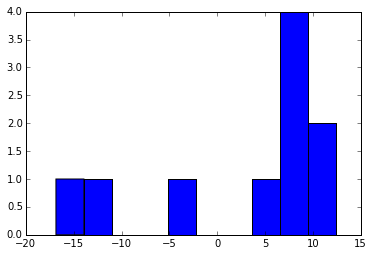

In [17]:
plt.hist(data,bins = 10)

In [19]:
from bayespy.nodes import Gamma, GaussianARD

In [25]:
mu = GaussianARD(0, 1e-6)
tau = Gamma(1e-6, 1e-6)
y = GaussianARD(mu, tau, plates=(10,))

In [28]:
y.observe(data)
from bayespy.inference import VB

In [31]:
Q = VB(mu, tau, y)
Q.update(repeat=20)

Iteration 1: loglike=-5.789001e+01 (0.003 seconds)
Iteration 2: loglike=-5.611578e+01 (0.003 seconds)
Iteration 3: loglike=-5.611343e+01 (0.002 seconds)
Iteration 4: loglike=-5.611340e+01 (0.002 seconds)
Converged at iteration 4.


In [35]:
import bayespy.plot as bpplt
bpplt.pyplot()

Exception: No plotter defined, can not plot

In [81]:
from bayespy.nodes import Gaussian, Wishart, Dot
mu = Gaussian([0, 0], [[1e-6, 0], [0, 1e-6]])
Lambda = Wishart(2, [[1, 0],[0, 1]])
X = Gaussian(mu, Lambda, name = 'x')

# PPCAの例
## グラフィカルモデルの作成

In [89]:


%%latex
$Y = CX^T + noise$　
と仮定する。ただし$Y$はM×Nのデータ行列で、CはM×Cのローディング行列、XはN×Dの潜在変数行列である

主成分分析で次元を削減するので、通常、Dの次元は、M,Nよりずっと小さくなる。確率的表現をすると

$$
p(Y) = \prod_{m=0}^{M-1}\prod_{n=0}^{N-1}N(y_{mn}|c_m^T,x_{mn},\tau)
$$
$$p(X) = \prod_{n=0}^{N-1}\prod_{d=0}^{D-1}N(x_{nd}|0,1)$$
$$p(C) = \prod$$
$$p（C） = \prod$$
...

長いので省略


<IPython.core.display.Latex object>

グラフィカルモデルで表すと
<img src="./img/Graphical_PPCA.jpg">

Cの事前確率としてautomatic relevance determination(ARD)が与えられていると考える

In [116]:
D = 3
X = GaussianARD(0, 1, shape=(D,),
               plates=(1, 100),
               name='X')
alpha = Gamma(1e-3, 1e-3,
             plates=(D,),
             name='alpha')
C = GaussianARD(0, alpha,
               shape=(D,),
               plates=(10,1),
               name='C')

In [117]:
F = Dot(C,X)

In [118]:
F.plates

(10, 100)

In [119]:
tau = Gamma(12-3, 1e-3, name='tau')  ##ノイズ
Y = GaussianARD(F, tau, name='Y')

## データの当てはめ

In [122]:
c = np.random.randn(10, 2)
x = np.random.randn(2, 100)
data = np.dot(c, x) + 0.1 * np.random.randn(10, 100)
Y.observe(data)

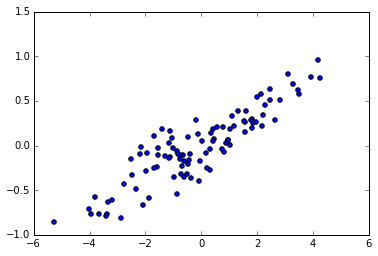

In [123]:
plt.scatter(data[0], data[1])

### 欠損値

In [128]:
Y.observe(data, mask=[[True], [False], [False], [True], [True],
                      [False], [True], [True], [True], [False]])
Y.plates

(10, 100)

Trueは値が観測されたことを、Falseはされなかったことを示す。
maskの形は(10, 1)なので(10, 100)であるYにブロードキャスティングされ、全ての行(100)に対して列2, 3, 6, 10が欠けている状態になる。
欠損値は自動的に周辺化される

## 推定

In [131]:
from bayespy.inference import VB
Q = VB(Y, C, X, alpha, tau)
Q['X']

### 初期化
X.initialize\*
を見ればどんな初期値を色々な方法で決定できることがわかる。
デフォルトは`initialize_from_prior()`

In [136]:
X.initialize_from_parameters(np.random.randn(1, 100, D), 10) #GaussianARDオブジェクトの場合、第二引数は精度行列を表すので分散は1/10になる

このように、Xの平均を散らすことが極めて重要である。なぜなら、デフォルトのinitializationは、平均を0にするため、なんかうまくいかない場合があるらしい

In [139]:
## iterateする
Q.update()
## 特定のノードを指定して、アップデートする
Q.update(C, X, C, tau)

##回数を指定してupdateする
Q.update(repeat=10)

Iteration 4: loglike=-9.876682e+02 (0.021 seconds)
Iteration 5: loglike=-7.530524e+02 (0.017 seconds)
Iteration 6: loglike=-6.223972e+02 (0.013 seconds)
Iteration 7: loglike=-4.901729e+02 (0.013 seconds)
Iteration 8: loglike=-4.123372e+02 (0.013 seconds)
Iteration 9: loglike=-3.803797e+02 (0.013 seconds)
Iteration 10: loglike=-3.697965e+02 (0.013 seconds)
Iteration 11: loglike=-3.653478e+02 (0.013 seconds)
Iteration 12: loglike=-3.622967e+02 (0.013 seconds)
Iteration 13: loglike=-3.596080e+02 (0.012 seconds)
Iteration 14: loglike=-3.570665e+02 (0.011 seconds)
Iteration 15: loglike=-3.546184e+02 (0.011 seconds)


In [142]:
## 十分な回数を行えば、自動的に収束する
## tolで閾値を指定
Q.update(repeat=1000, tol = 1e-3)

Iteration 2016: loglike=-1.486560e+02 (0.015 seconds)
Converged at iteration 2016.


In [143]:
## それぞれのノードを直接アップデートすることも可能だが、特別な理由がない限りしない方がいい
C.update()
Q['C'].update()

#### parameter expansion
時にVBは収束が遅くなることがある。これは変数同士が、真の事後分布において強く相関(coupled)しているが、approximate posteriorで周辺化されている場合に起こる。variational variablesのsigzagingにつながる(?)ためである。
こういった場合、parameter expansion を使用する.
これは、auxiliary variablesを用いていくつかの変数をparameterizeし、推定することで、いくつかの事後分布を求めるので高速になる。
model specificである。

以下のように分解する。

In [146]:
%%latex

$$
y = c^Tx + noise = c^TRR^{-1} + noise = (R^Tc)^T(R^{-1}x) + noise
$$

<IPython.core.display.Latex object>

In [147]:
from bayespy.inference.vmp import transformations
rotX = transformations.RotateGaussianARD(X)
rotC = transformations.RotateGaussianARD(C, alpha)

In [149]:
R = transformations.RotationOptimizer(rotC, rotX, D)
R.rotate()

In [151]:
alpha.initialize_from_prior()
C.initialize_from_prior()
X.initialize_from_parameters(np.random.rand(1, 100, D), 10)
tau.initialize_from_prior()
Q = VB(Y, C, X, alpha, tau)

In [152]:
## それぞれのiterationごとにrotationが走るようにする
Q.callback = R.rotate

In [154]:
Q.update(repeat=1000, tol=1e-6)#より少ない反復で収束する

Iteration 14: loglike=-1.483548e+02 (0.021 seconds)
Iteration 15: loglike=-1.483492e+02 (0.013 seconds)
Iteration 16: loglike=-1.483452e+02 (0.013 seconds)
Iteration 17: loglike=-1.483423e+02 (0.013 seconds)
Iteration 18: loglike=-1.483402e+02 (0.011 seconds)
Iteration 19: loglike=-1.483386e+02 (0.011 seconds)
Iteration 20: loglike=-1.483374e+02 (0.011 seconds)
Iteration 21: loglike=-1.483365e+02 (0.011 seconds)
Iteration 22: loglike=-1.483358e+02 (0.011 seconds)
Iteration 23: loglike=-1.483352e+02 (0.011 seconds)
Iteration 24: loglike=-1.483348e+02 (0.011 seconds)
Iteration 25: loglike=-1.483345e+02 (0.011 seconds)
Iteration 26: loglike=-1.483342e+02 (0.011 seconds)
Iteration 27: loglike=-1.483339e+02 (0.011 seconds)
Iteration 28: loglike=-1.483337e+02 (0.011 seconds)
Iteration 29: loglike=-1.483336e+02 (0.011 seconds)
Iteration 30: loglike=-1.483334e+02 (0.011 seconds)
Converged at iteration 30.


### 結果の分析

In [155]:
import bayespy.plot as bpplot

In [157]:
bpplt.pyplot.ion() #enable interacting plot

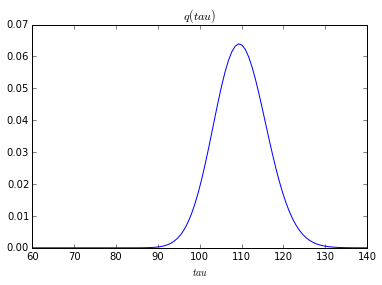

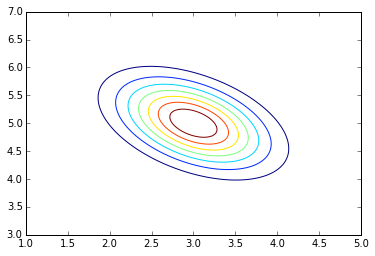

In [168]:
bpplt.pdf(Q['tau'], np.linspace(60, 140, num=100)) #スカラー値の確率分布を表示
V = Gaussian([3, 5], [[4, 2], [2, 5]])
bpplt.pyplot.figure()
bpplt.contour(V, np.linspace(1, 5, num=100), np.linspace(3, 7, num = 100))

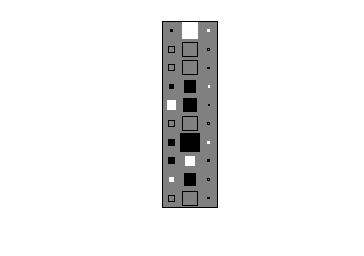

In [169]:
bpplot.pyplot.figure()
bpplt.hinton(C)

行列Cのそれぞれの要素を示す。白または黒で塗りつぶされている正方形は要素の平均を表し、大きさは絶対値に対応している。白は正、黒は負を表す
